In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 0 for the experiment.


In [2]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import keras as keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2023-12-02 16:30:59.816535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Prepare Training Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [4]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full seq_model model
    seq_model_outputs = decoder_model(encoder_lstm)
    seq_model = Model(encoder_inputs, seq_model_outputs)
    
    # Compile the model
    seq_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    seq_model.summary()
    return seq_model

In [5]:
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:0'):
        save_path = "./Saved_Models_Data/P40_U128_OA/"
        seq_model = createModel(128,'adam')
        early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = seq_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history.json','w') as file:
            json.dump(history.history, file)
else:
    print("No GPU available.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-02 16:32:32.193506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 model_1 (Functional)        (None, 81, 1)             131713    
                                                                 
Total params: 198273 (774.50 KB)
Trainable params: 198273 (774.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2023-12-02 16:32:36.958294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-02 16:32:37.102818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-02 16:32:37.103564: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f185c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 16:32:37.103600: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-12-02 16:32:37.112028: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-02 16:32:37.229672: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

1243/1244 [============================>.] - ETA: 0s - loss: 0.1034 - mae: 0.2094
Epoch 1: val_loss improved from inf to 0.07932, saving model to ./Saved_Models_Data/P40_U128_OA/best_enc_dec.h5
1244/1244 [==============================] - 20s 13ms/step - loss: 0.1034 - mae: 0.2094 - val_loss: 0.0793 - val_mae: 0.1677
Epoch 2/200
  10/1244 [..............................] - ETA: 14s - loss: 0.0805 - mae: 0.1681

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1243/1244 [============================>.] - ETA: 0s - loss: 0.0834 - mae: 0.1690
Epoch 2: val_loss improved from 0.07932 to 0.07366, saving model to ./Saved_Models_Data/P40_U128_OA/best_enc_dec.h5
1244/1244 [==============================] - 16s 13ms/step - loss: 0.0834 - mae: 0.1690 - val_loss: 0.0737 - val_mae: 0.1475
Epoch 3/200
1240/1244 [============================>.] - ETA: 0s - loss: 0.0838 - mae: 0.1652
Epoch 3: val_loss did not improve from 0.07366
1244/1244 [==============================] - 16s 13ms/step - loss: 0.0838 - mae: 0.1651 - val_loss: 0.0771 - val_mae: 0.1510
Epoch 4/200
1240/1244 [============================>.] - ETA: 0s - loss: 0.0721 - mae: 0.1420
Epoch 4: val_loss improved from 0.07366 to 0.06653, saving model to ./Saved_Models_Data/P40_U128_OA/best_enc_dec.h5
1244/1244 [==============================] - 16s 13ms/step - loss: 0.0720 - mae: 0.1420 - val_loss: 0.0665 - val_mae: 0.1314
Epoch 5/200
1240/1244 [============================>.] - ETA: 0s - loss: 0.0

In [6]:
save_path = "./Saved_Models_Data/P40_U128_OA/"
f = open(save_path+"history.json")
history = json.load(f)

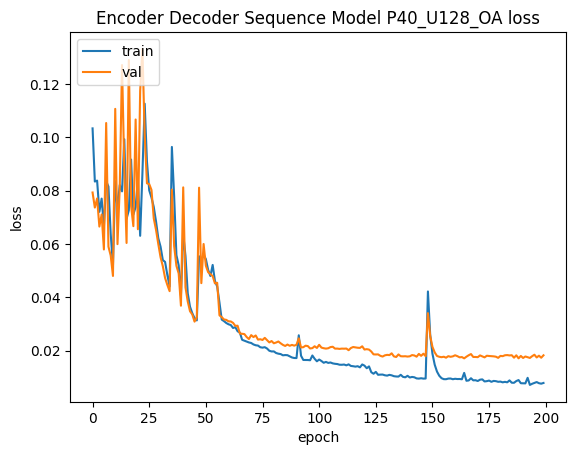

In [7]:
# summarize history for loss
mod_name = "P40_U128_OA"
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Encoder Decoder Sequence Model '+mod_name+' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
#Evaluate the saved best model:
from keras.models import load_model
saved_model = load_model(save_path+"best_enc_dec.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 6ms/step - loss: 0.0171 - mae: 0.0267
Mean Squared Error:  0.01714911125600338
Mean Absolute Error:  0.026725055649876595
Root Mean Squared Error (RMSE):  0.13095461525277902


In [9]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth.npy", Y_test)

389/389 [==============================] - 2s 5ms/step


In [10]:
#print some samples
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path +"ground-truth.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.0009019389981403947
Index 1 Ground truth: 0 Predicted: 0.18050840497016907
Index 2 Ground truth: 1 Predicted: 0.953060507774353
Index 3 Ground truth: 0 Predicted: 0.00012550961400847882
Index 4 Ground truth: 0 Predicted: 3.38299560098676e-06
Index 5 Ground truth: 0 Predicted: 6.516818871205032e-07
Index 6 Ground truth: 0 Predicted: 5.365438369153708e-07
Index 7 Ground truth: 0 Predicted: 4.465189704205841e-05
Index 8 Ground truth: 0 Predicted: 1.4156257748254575e-06
Index 9 Ground truth: 0 Predicted: 2.2409734810935333e-05
Index 10 Ground truth: 0 Predicted: 0.0016987691633403301
Index 11 Ground truth: 0 Predicted: 7.904504855105188e-07
Index 12 Ground truth: 0 Predicted: 0.0002020645042648539
Index 13 Ground truth: 1 Predicted: 0.999653697013855
Index 14 Ground truth: 0 Predicted: 0.0006354573415592313
Index 15 Ground truth: 0 Predicted: 3.15996794597595e-06
Index 16 Ground truth: 0 Predicted: 3.3767075819923775e-0

In [11]:
#Can convert to Benesh version for predictions using a threshold here (0.5)
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [12]:
#save the error array
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr.npy",err_arr)

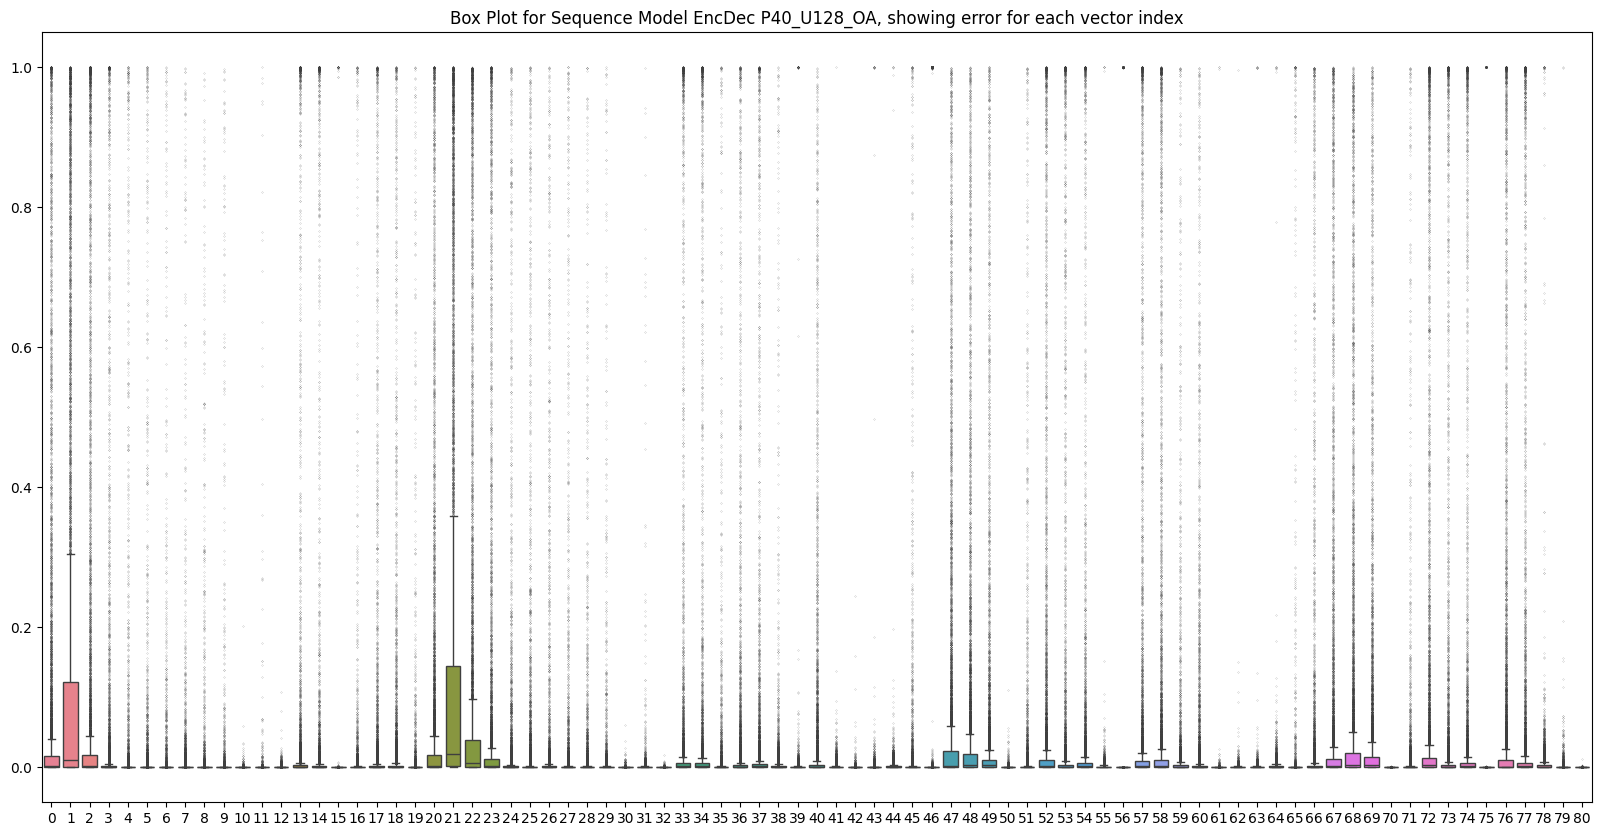

In [13]:
err_arr = np.load(save_path+"err_arr.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Sequence Model EncDec '+mod_name+', showing error for each vector index')
plt.show()

In [14]:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples*100 # Multiply by 100 to get the percentage
    print("OVERALL MAPE: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.01212748 0.00991594 0.01579688 0.00835336 0.0223447  0.01245745
 0.05592176 0.13027531 0.01293327 0.02670896]
OVERALL MAPE:  2.672504707218168


In [15]:
from sklearn.metrics import r2_score

In [16]:
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

In [17]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.97469668 0.97562718 0.95923185 ... 0.93260479 0.72817526 0.84723421]
Overall R-squared value: 0.8641119195846683


In [18]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61535237 0.61535237 0.61535237 ... 0.61535237 0.51428    0.61237965]
Overall Spearman correlation coefficient: 0.6004132332123695


In [19]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.98747609 0.98788957 0.97956426 ... 0.97011513 0.85525987 0.92221196]
12433
Overall Pearson correlation coefficient: 0.9288666751949567


In [20]:
from sklearn.metrics import matthews_corrcoef #calculated using the converted 0.5 threshold benesh vector
y_pred = np.load(save_path + "y_pred_benesh.npy")
y_true = np.load(save_path + "ground-truth.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.9153187567757366


In [1]:
#Save boxplot stats
import numpy as np
mod_name = "P40_U128_OA"
save_path = "./Saved_Models_Data/"+mod_name+"/" #*UDATE HERE*

np.set_printoptions(suppress=True) # Disable scientific notation
filename = "err_arr.npy"

err = np.load(save_path+filename)
print(len(err))

stats = np.empty(shape = (0,5))
n_indices = len(err[0]) # should be 81
print(n_indices)

for i in range(n_indices):
    i_stats = np.percentile(err[:, i], [0, 25, 50, 75, 100]) # = [Min, Q1, Med, Q3, Max]
    stats = np.vstack([stats, i_stats]) # Add row to numpy stats object 
    print("index: {}".format(i), i_stats)

# print(stats)
out_filename = "boxplot_stats_"+mod_name+".csv"

np.savetxt(save_path+out_filename, stats, delimiter = ',', fmt='%f')

12433
81
index: 0 [0.00000012 0.00011022 0.00112855 0.01610917 0.9999989 ]
index: 1 [0.00000002 0.00059459 0.01088163 0.1220414  0.99999832]
index: 2 [0.         0.000085   0.00120825 0.01777842 1.        ]
index: 3 [0.         0.00002222 0.00021729 0.00166748 0.99999994]
index: 4 [0.         0.00000054 0.00000565 0.00007715 0.99999391]
index: 5 [0.         0.00000278 0.00001842 0.00013138 0.99999985]
index: 6 [0.         0.00000024 0.00000173 0.00002305 0.99999878]
index: 7 [0.         0.00000397 0.0000248  0.00015425 0.99908334]
index: 8 [0.         0.00000305 0.00001988 0.00010773 0.99235537]
index: 9 [0.00000001 0.00000541 0.00002329 0.00010635 0.99752257]
index: 10 [0.00000003 0.00000731 0.00002614 0.00008704 0.2015886 ]
index: 11 [0.         0.00000061 0.00000386 0.00002296 0.99990357]
index: 12 [0.00000001 0.00000695 0.00002931 0.00013386 0.10814385]
index: 13 [0.0000006  0.00018638 0.0006426  0.00267132 0.99999249]
index: 14 [0.00000003 0.00009037 0.00043619 0.00218642 0.999999

7303
Perplexity value: 130
[t-SNE] Computing 391 nearest neighbors...
[t-SNE] Indexed 12433 samples in 0.000s...
[t-SNE] Computed neighbors for 12433 samples in 1.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12433
[t-SNE] Computed conditional probabilities for sample 2000 / 12433
[t-SNE] Computed conditional probabilities for sample 3000 / 12433
[t-SNE] Computed conditional probabilities for sample 4000 / 12433
[t-SNE] Computed conditional probabilities for sample 5000 / 12433
[t-SNE] Computed conditional probabilities for sample 6000 / 12433
[t-SNE] Computed conditional probabilities for sample 7000 / 12433
[t-SNE] Computed conditional probabilities for sample 8000 / 12433
[t-SNE] Computed conditional probabilities for sample 9000 / 12433
[t-SNE] Computed conditional probabilities for sample 10000 / 12433
[t-SNE] Computed conditional probabilities for sample 11000 / 12433
[t-SNE] Computed conditional probabilities for sample 12000 / 12433
[t-SNE] Computed condi

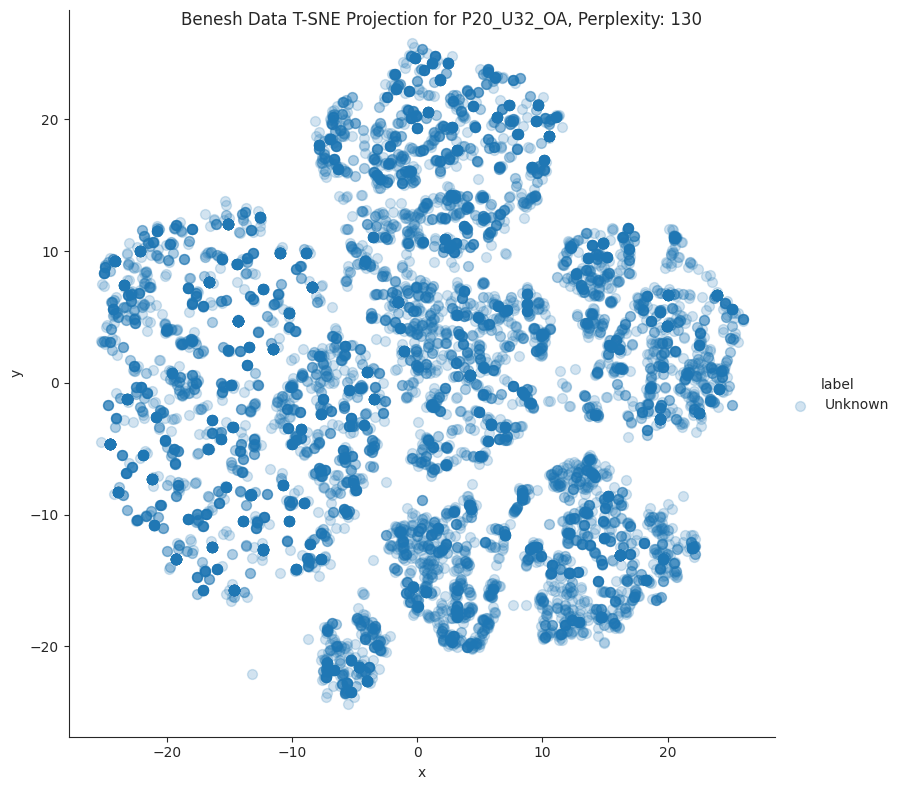

In [21]:
#Plot the TSNE of the predicted data...
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import json
from sklearn.manifold import TSNE

path_to_dict = "../Normalised/GT_Lookup_Dict.json"
path_to_Benesh_Vec = "./Saved_Models_Data/P40_U128_OA/y_pred_benesh.npy"

lookup_dict = {}

with open(path_to_dict) as file:
    lookup_dict = json.load(file)
print(len(lookup_dict))

Y = np.load(path_to_Benesh_Vec)

def getLabels(data, dict):
    gt_labels = []
    for i in range(len(data)):
        gt_str = np.array2string(data[i])
        gt_lab = dict.get(gt_str, None)
        if gt_lab is not None:
            gt_labels.append(gt_lab)
        else:
            print("Could not find the vector in lookup dictionary...labelling as unknown...")
            gt_labels.append("Unknown")
            #sys.stdout.flush()
            #exit(1)
    return gt_labels

pps = [5, 30, 55, 80, 105, 130] #different perpexity values
#test with perplexity 130 for now
p = 5 #130
perplexity = pps[p]

print("Perplexity value:", str(perplexity))
tsne = TSNE(n_components=2, random_state=0, verbose=1, perplexity=pps[p], learning_rate=10)
tsne_out = tsne.fit_transform(Y) #returns a new ndarray of shape (nsamples, n_components) -> our case: (62 163,2)
tsne_frame = pd.DataFrame(np.row_stack(tsne_out), columns=['x', 'y'])
gt_labels = getLabels(Y,lookup_dict)
# We need better progress functions ... 
tsne_frame['label'] = gt_labels 
tsne_framesub = tsne_frame.copy()
# sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot(x='x', y='y',
            data=tsne_framesub,
            fit_reg=False,
            legend=True,
            height=8,
            hue='label',
            scatter_kws={"s":50, "alpha":0.2}).fig.suptitle("Benesh Data T-SNE Projection for P20_U32_OA, Perplexity: "+str(perplexity))
plt.show()
